Perform Imports

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
import csv
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io

First, we load in the data.

In [6]:
with open("./data/training_data_new.json", 'r') as f:
    datastore = json.load(f)

with open("./data/training_data_pj.json", 'r') as f:
    datastore += json.load(f)

headlines = []
labels = []

for item in datastore:
    headlines.append(item['title'])
    labels.append(item['good_news'])

with open("./data/kaggle.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for line in reader:
        label = line[0]
        headline = line[1]
        # if random.randint(0, 1) >= .5:
        #     continue
        if label == "positive":
            labels.append(1)
        else:
            labels.append(0)
        headlines.append(headline)

print(f"Postive: {labels.count(1)}, Negative: {labels.count(0)}")

Postive: 2085, Negative: 3728


Download nltk resources

In [7]:
nltk.download ()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Remove stop words and contractions.

In [8]:
lem = False
stem = True
v2 = True

if v2:
    stemmer = SnowballStemmer(language='english')
else:
    stemmer = PorterStemmer()
lemmmatizer = WordNetLemmatizer()

def preProcess(sentence):
    words = []
    for word in sentence.split():
        #Take out all non letter characters
        #word = re.sub("[^a-zA-Z]+", "", word.lower())
        word = word.lower()
        if word not in stopwords.words('english') and word != "":
            if lem:
                newWord = lemmmatizer.lemmatize(word)
            elif stem:
                newWord = stemmer.stem(word)
            else:
                newWord = word
            words.append(newWord.replace("'", ""))

    return ' '.join(words)


In [9]:
for i in range(len(headlines)):
    headlines[i] = preProcess(headlines[i])

Split the data.

In [10]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(headlines, labels, train_size=0.90)
print(f"Split into {len(training_headlines)} Training sets and {len(testing_headlines)} Testing sets.")

Split into 5231 Training sets and 582 Testing sets.


Tune Hyperparameters.

In [11]:
vocab_size = 10000
max_length = 35
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

In [12]:
def tune_hyper(vocab_size, max_length, training_headlines, testing_headlines, training_labels, testing_labels):    
    


    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

    # training tokenizer
    #tokenizer.word_index = word_index

    tokenizer.fit_on_texts(training_headlines)

    print(f"Word Index Size: {len(tokenizer.word_index)}")
    return tokenizer

tokenizer = tune_hyper(vocab_size, max_length, training_headlines, testing_headlines, training_labels, testing_labels)

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 8916


Define MCC Metric

In [104]:
threshold = 0.5  

def mcc_metric(y_true, y_pred):
  predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [13]:
embedding_dim = 16
batch_size = 32
epochs = 50
learning_rate = 1e-4

In [14]:
tf.keras.backend.clear_session()

baseline = tf.keras.Sequential([
    # tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    # tf.keras.layers.GlobalMaxPooling1D(),
    # tf.keras.layers.Dropout(0.5),
    # #tf.keras.layers.Dense(512, activation="relu"),
    # #tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(4, activation="relu"),
    # tf.keras.layers.Dense(1, activation="sigmoid")
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

baseline.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

Train model.

In [15]:
idx = 11

In [16]:
class prediction_for_each_epoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        prediction = model.predict(np.expand_dims(testing_padded[idx], axis=0))
        print(f"\n Prediction: {prediction[0][0]} Actual: {testing_labels[idx]}")

In [17]:
tf.keras.backend.clear_session()

In [18]:
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

string = ""
for word in testing_padded[idx]:
    if word == 0:
        string += "."
        break
    string += tokenizer.index_word[word] + " "
print(f"Sentence is '{string}'")

history = baseline.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Sentence is 'mill capac produc 500 000 tonn pulp per year .'
Epoch 1/50
 26/164 [===>..........................] - ETA: 3:09 - loss: 0.6679 - accuracy: 0.6406 - false_positives: 20.0000 - false_negatives: 279.0000

KeyboardInterrupt: 

adding MaxPooling1D Layer

In [26]:
tf.keras.backend.clear_session()

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_1.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [27]:
history_1 = model_1.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 291ms/step loss: 0.6570 - accuracy: 0.6368 - false_positives: 30.0000 - false_negatives: 1870.00

 Prediction: 0.49398550391197205 Actual: 0
164/164 [==============================] - 12s 36ms/step - loss: 0.6570 - accuracy: 0.6368 - false_positives: 30.0000 - false_negatives: 1870.0000 - val_loss: 0.6242 - val_accuracy: 0.6615 - val_false_positives: 0.0000e+00 - val_false_negatives: 197.0000
Epoch 2/50
1/1 [==============================] - 0s 20ms/step- loss: 0.5750 - accuracy: 0.7064 - false_positives: 431.0000 - false_negatives: 1091.00

 Prediction: 0.49398550391197205 Actual: 0
164/164 [==============================] - 4s 26ms/step - loss: 0.5740 - accuracy: 0.7071 - false_positives: 434.0000 - false_negatives: 1098.0000 - val_loss: 0.5753 - val_accuracy: 0.6787 - val_false_positives: 100.0000 - val_false_negatives: 87.0000
Epoch 3/50
1/1 [==============================] - 0s 25ms/step- loss: 0.4461 - accuracy: 0.8011 - false_

same as above but taking out dense layer after MaxPooling1D

In [28]:
tf.keras.backend.clear_session()

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_2.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [29]:
history_2 = model_2.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 251ms/step loss: 0.6519 - accuracy: 0.6429 - false_positives: 48.0000 - false_negatives: 1820.00

 Prediction: 0.49398550391197205 Actual: 0
164/164 [==============================] - 11s 35ms/step - loss: 0.6519 - accuracy: 0.6429 - false_positives: 48.0000 - false_negatives: 1820.0000 - val_loss: 0.6115 - val_accuracy: 0.6838 - val_false_positives: 11.0000 - val_false_negatives: 173.0000
Epoch 2/50
1/1 [==============================] - 0s 19ms/step- loss: 0.5653 - accuracy: 0.7166 - false_positives: 388.0000 - false_negatives: 1081.00

 Prediction: 0.49398550391197205 Actual: 0
164/164 [==============================] - 4s 25ms/step - loss: 0.5659 - accuracy: 0.7161 - false_positives: 392.0000 - false_negatives: 1093.0000 - val_loss: 0.5477 - val_accuracy: 0.7216 - val_false_positives: 34.0000 - val_false_negatives: 128.0000
Epoch 3/50
1/1 [==============================] - 0s 18ms/step- loss: 0.4465 - accuracy: 0.7957 - false_pos

reducing vocab size from 10k --> 5k

In [112]:
tf.keras.backend.clear_session()
vocab_size = 5000
tokenizer = tune_hyper(vocab_size, max_length, training_headlines, testing_headlines, training_labels, testing_labels)

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 8868


In [113]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_3.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [114]:
history_3 = model_3.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 246ms/step loss: 0.6488 - accuracy: 0.6439 - false_positives: 55.0000 - false_negatives: 1808.00

 Prediction: 0.4934248924255371 Actual: 0
164/164 [==============================] - 10s 34ms/step - loss: 0.6488 - accuracy: 0.6439 - false_positives: 55.0000 - false_negatives: 1808.0000 - val_loss: 0.5871 - val_accuracy: 0.6959 - val_false_positives: 47.0000 - val_false_negatives: 130.0000
Epoch 2/50
1/1 [==============================] - 0s 16ms/step- loss: 0.5512 - accuracy: 0.7242 - false_positives: 413.0000 - false_negatives: 1017.00

 Prediction: 0.4934248924255371 Actual: 0
164/164 [==============================] - 4s 25ms/step - loss: 0.5518 - accuracy: 0.7238 - false_positives: 415.0000 - false_negatives: 1030.0000 - val_loss: 0.5513 - val_accuracy: 0.7199 - val_false_positives: 18.0000 - val_false_negatives: 145.0000
Epoch 3/50
1/1 [==============================] - 0s 17ms/step- loss: 0.4516 - accuracy: 0.7895 - false_posit

with 7.5k vocab size

In [49]:
tf.keras.backend.clear_session()
vocab_size = 7500
tokenizer = tune_hyper(vocab_size, max_length, training_headlines, testing_headlines, training_labels, testing_labels)

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 8916


In [50]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_4.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [51]:
history_4 = model_4.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 309ms/step loss: 0.6547 - accuracy: 0.6391 - false_positives: 0.0000e+00 - false_negatives: 1888.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 14s 42ms/step - loss: 0.6547 - accuracy: 0.6391 - false_positives: 0.0000e+00 - false_negatives: 1888.0000 - val_loss: 0.6493 - val_accuracy: 0.6615 - val_false_positives: 0.0000e+00 - val_false_negatives: 197.0000
Epoch 2/50
1/1 [==============================] - 0s 18ms/step- loss: 0.5975 - accuracy: 0.6863 - false_positives: 221.0000 - false_negatives: 1415.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 5s 32ms/step - loss: 0.5969 - accuracy: 0.6867 - false_positives: 222.0000 - false_negatives: 1417.0000 - val_loss: 0.5623 - val_accuracy: 0.6890 - val_false_positives: 116.0000 - val_false_negatives: 65.0000
Epoch 3/50
1/1 [==============================] - 0s 21ms/step- loss: 0.4417 - accuracy: 0.7993 - fa

increase word_length to 50

In [52]:
tf.keras.backend.clear_session()
vocab_size = 10000
max_length = 50
tokenizer = tune_hyper(vocab_size, max_length, training_headlines, testing_headlines, training_labels, testing_labels)

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 8916


In [53]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_5.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [54]:
history_5 = model_5.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 294ms/step loss: 0.6557 - accuracy: 0.6384 - false_positives: 5.0000 - false_negatives: 1881.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 14s 42ms/step - loss: 0.6557 - accuracy: 0.6385 - false_positives: 5.0000 - false_negatives: 1886.0000 - val_loss: 0.6311 - val_accuracy: 0.6615 - val_false_positives: 0.0000e+00 - val_false_negatives: 197.0000
Epoch 2/50
1/1 [==============================] - 0s 23ms/step- loss: 0.5813 - accuracy: 0.6911 - false_positives: 348.0000 - false_negatives: 1263.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 5s 32ms/step - loss: 0.5823 - accuracy: 0.6907 - false_positives: 350.0000 - false_negatives: 1268.0000 - val_loss: 0.5766 - val_accuracy: 0.7268 - val_false_positives: 23.0000 - val_false_negatives: 136.0000
Epoch 3/50
1/1 [==============================] - 0s 18ms/step- loss: 0.4537 - accuracy: 0.7985 - false_posi

try custom changes

In [55]:
tf.keras.backend.clear_session()
vocab_size = 8000
max_length = 50
tokenizer = tune_hyper(vocab_size, max_length, training_headlines, testing_headlines, training_labels, testing_labels)

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 8916


In [56]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_6.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [57]:
history_6 = model_6.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 321ms/step loss: 0.6852 - accuracy: 0.6055 - false_positives: 386.0000 - false_negatives: 1659.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 11s 35ms/step - loss: 0.6852 - accuracy: 0.6056 - false_positives: 386.0000 - false_negatives: 1677.0000 - val_loss: 0.6691 - val_accuracy: 0.6615 - val_false_positives: 0.0000e+00 - val_false_negatives: 197.0000
Epoch 2/50
1/1 [==============================] - 0s 22ms/step- loss: 0.6628 - accuracy: 0.6394 - false_positives: 0.0000e+00 - false_negatives: 1881.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 4s 23ms/step - loss: 0.6630 - accuracy: 0.6391 - false_positives: 0.0000e+00 - false_negatives: 1888.0000 - val_loss: 0.6410 - val_accuracy: 0.6615 - val_false_positives: 0.0000e+00 - val_false_negatives: 197.0000
Epoch 3/50
1/1 [==============================] - 0s 18ms/step- loss: 0.6506 - accuracy: 0.6390 -

custom training with decreased dimensions 

In [84]:
tf.keras.backend.clear_session()
vocab_size = 10000
max_length = 50
tokenizer = tune_hyper(vocab_size, max_length, training_headlines, testing_headlines, training_labels, testing_labels)

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 8916


In [85]:
embedding_dim = 12
model_7 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_7.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [86]:
history_7 = model_7.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 302ms/step loss: 0.6568 - accuracy: 0.6378 - false_positives: 13.0000 - false_negatives: 1876.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 14s 40ms/step - loss: 0.6568 - accuracy: 0.6379 - false_positives: 13.0000 - false_negatives: 1881.0000 - val_loss: 0.6340 - val_accuracy: 0.6615 - val_false_positives: 0.0000e+00 - val_false_negatives: 197.0000
Epoch 2/50
1/1 [==============================] - 0s 18ms/step- loss: 0.6181 - accuracy: 0.6647 - false_positives: 167.0000 - false_negatives: 1582.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 5s 30ms/step - loss: 0.6190 - accuracy: 0.6641 - false_positives: 168.0000 - false_negatives: 1589.0000 - val_loss: 0.5461 - val_accuracy: 0.7113 - val_false_positives: 58.0000 - val_false_negatives: 110.0000
Epoch 3/50
1/1 [==============================] - 0s 18ms/step- loss: 0.4804 - accuracy: 0.7747 - false_po

another smaller model

In [88]:
embedding_dim = 10
model_8 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_8.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [89]:
history_8 = model_8.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Epoch 1/50
1/1 [==============================] - 0s 17ms/step- loss: 0.6867 - accuracy: 0.6389 - false_positives_1: 1.0000 - false_negatives_1: 1871.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 6s 19ms/step - loss: 0.6866 - accuracy: 0.6391 - false_positives_1: 1.0000 - false_negatives_1: 1887.0000 - val_loss: 0.6762 - val_accuracy: 0.6615 - val_false_positives_1: 0.0000e+00 - val_false_negatives_1: 197.0000
Epoch 2/50
1/1 [==============================] - 0s 17ms/step- loss: 0.6668 - accuracy: 0.6380 - false_positives_1: 0.0000e+00 - false_negatives_1: 1865.00

 Prediction: 0.4931558072566986 Actual: 0
164/164 [==============================] - 2s 13ms/step - loss: 0.6662 - accuracy: 0.6391 - false_positives_1: 0.0000e+00 - false_negatives_1: 1888.0000 - val_loss: 0.6478 - val_accuracy: 0.6615 - val_false_positives_1: 0.0000e+00 - val_false_negatives_1: 197.0000
Epoch 3/50
1/1 [==============================] - 0s 17ms/step- loss: 0.6542 -

Plot findings.

In [75]:
def plot_graphs(history, string, x, y, ax):
    ax[x,y].plot(history.history[string])
    ax[x,y].plot(history.history['val_'+string])
    ax[x,y].set_xlabel("Epochs")
    ax[x,y].set_ylabel(string)
    ax[x,y].legend([string, 'val_'+string])

def plot_lr(history):
    lrs = 1e-8 * (10 ** (np.arange(epochs) / 20))

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the grid
    plt.grid(True)

    # Plot the loss in log scale
    plt.semilogx(lrs, history.history["val_loss"])

    # Increase the tickmarks size
    plt.tick_params('both', length=10, width=1, which='both')

    # Set the plot boundaries
    plt.axis([1e-8, 1e-3, 0, 2])
    plt.show()

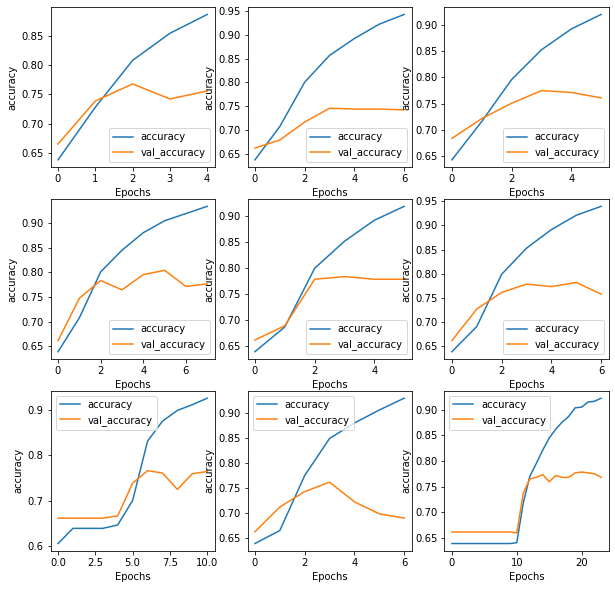

In [90]:
#plot_lr(history)
f, ax = plt.subplots(3, 3,figsize=(10, 10))
plot_graphs(history, "accuracy", 0, 0, ax)
plot_graphs(history_1, "accuracy", 0, 1, ax)
plot_graphs(history_2, "accuracy", 0, 2, ax)
plot_graphs(history_3, "accuracy", 1, 0, ax)
plot_graphs(history_4, "accuracy", 1, 1, ax)
plot_graphs(history_5, "accuracy", 1, 2, ax)
plot_graphs(history_6, "accuracy", 2, 0, ax)
plot_graphs(history_7, "accuracy", 2, 1, ax)
plot_graphs(history_8, "accuracy", 2, 2, ax)

# plot_graphs(history, "loss")
# plot_graphs(history, "false_positives")

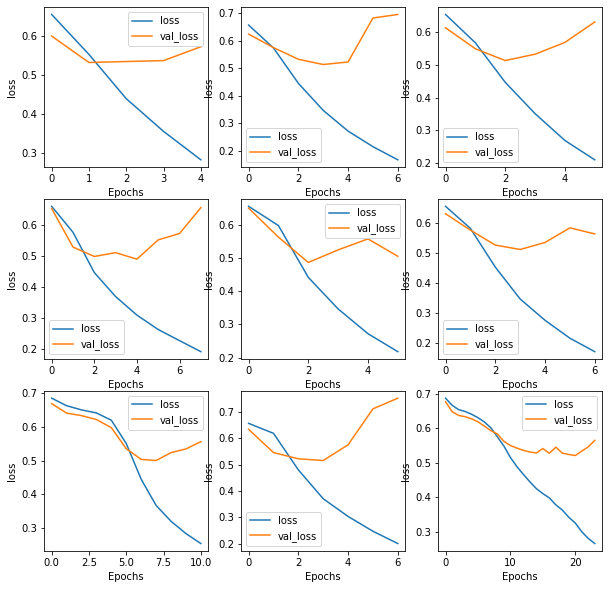

In [91]:
f, ax = plt.subplots(3, 3,figsize=(10, 10))
plot_graphs(history, "loss", 0, 0, ax)
plot_graphs(history_1, "loss", 0, 1, ax)
plot_graphs(history_2, "loss", 0, 2, ax)
plot_graphs(history_3, "loss", 1, 0, ax)
plot_graphs(history_4, "loss", 1, 1, ax)
plot_graphs(history_5, "loss", 1, 2, ax)
plot_graphs(history_6, "loss", 2, 0, ax)
plot_graphs(history_7, "loss", 2, 1, ax)
plot_graphs(history_8, "loss", 2, 2, ax)

# Overview of model experimentation

| model #                        | val_accuracy | val_loss | false_positives | false_negatives |
|--------------------------------|--------------|----------|-----------------|-----------------|
| baseline                       | 0.7749       | 0.5903   | 31              | 100             |
| model_1(maxPool)               | 0.7423       | 0.6955   | 83              | 67              |
| model_2(no dense)              | 0.7612       | 0.6291   | 23              | 116             |
| model_3(5k vocab)              | 0.7801       | 0.6703   | 41              | 87              |
| model_4(7.5k vocab)            | 0.7835       | 0.5239   | 52              | 74              |
| model_5(50 word length)        | 0.7784       | 0.5122   | 46              | 83              |
| model_6(custom1)               | 0.7251       | 0.5239   | 122             | 38              |
| model_7(custom2 w smaller dim) | 0.6890       | 0.7522   | 145             | 36              |
| model_8(smaller custom model)  | 0.7680       | 0.5642   | 59              | 76              |

Download Embedding Space

In [ ]:
# Open writeable files
out_v = io.open('embeds/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('embeds/meta.tsv', 'w', encoding='utf-8')

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, len(tokenizer.word_index)):

  # Get the word associated at the current index
  word_name = tokenizer.index_word[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

Save model

In [13]:
model.save("models/model.h5")
with open("models/word_index.json", "w+", encoding="utf-8") as _file:
    _file.write(json.dumps(tokenizer.word_index, indent=4))

: 